In [343]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.datasets import electrocardiogram
from scipy.signal import find_peaks, argrelmin, find_peaks_cwt
import pandas as pd
from collections import Counter
from scipy import signal


In [344]:
from sklearn.linear_model import SGDRegressor 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error 


from sklearn.pipeline import make_pipeline


In [345]:
path = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a001/a001.initial.Calibration_start_3.tsv"
path = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a002/a002.initial.Static_seated_challenge_1.tsv"
#path ="/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a004/a004.initial.Exercise_challenge_start_1.tsv"
#path = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a000/a000.initial.Static_challenge_start_1.tsv"


#path ="/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a000/a000.initial.Static_seated_challenge_1.tsv"

In [346]:
# df = pd.read_csv(path,sep = '\t')   
# pos_pressure = df["pressure"]

# for i in range(80,200,10):

#     neglist = [ -x for x in pos_pressure]

#     min_peaks, _ = find_peaks(neglist, prominence=10, width=100 )


#     plt.plot(pos_pressure)
#     plt.plot(min_peaks, pos_pressure[min_peaks], "x")
#     plt.title(f"mins {i} pro w/ len {len(min_peaks)}")
#     plt.show()

In [347]:
df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

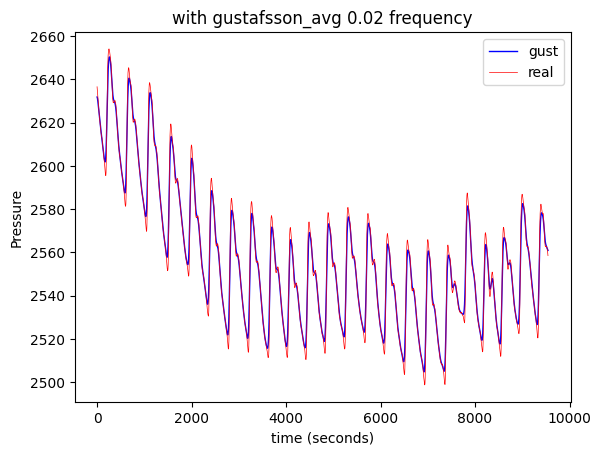

In [381]:
df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]


b, a = signal.butter(1, 0.02, analog=False)
gustafsson_avg = signal.filtfilt(b, a, x= pos_pressure, method="gust")
plt.plot(gustafsson_avg, 'b-', linewidth=1, label='gust')
plt.plot(pos_pressure,  linewidth=0.5, label='real', color= "red")

plt.title("with gustafsson_avg 0.02 frequency")
plt.legend(loc='best')
plt.ylabel("Pressure")
plt.xlabel("time (seconds)")
plt.show()

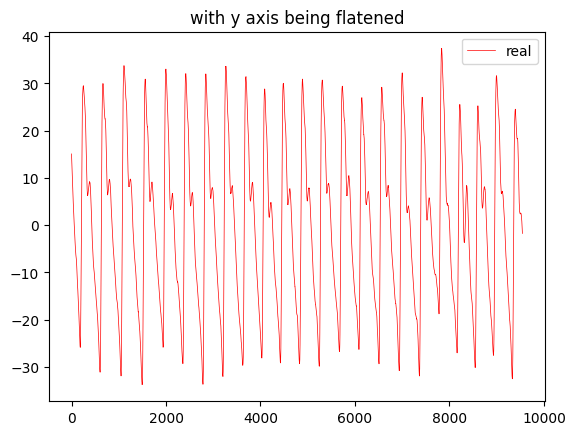

In [349]:
##flat it out with HZ as 0.002

y_flater = [real_pre-abs( guston_avg) for real_pre, guston_avg in zip(pos_pressure, gustafsson_avg)]

plt.plot(y_flater,  linewidth=0.5, label='real', color= "red")

plt.title("with y axis being flatened")
plt.legend(loc='best')
plt.show()

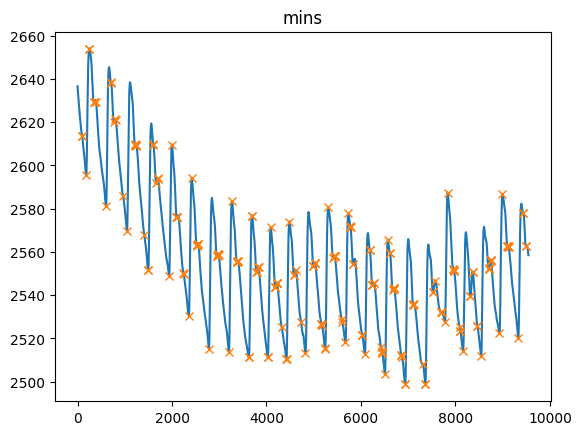

In [350]:

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

neglist = [ -x for x in y_flater]

min_peaks, _ = find_peaks(neglist)


plt.plot(pos_pressure)
plt.plot(min_peaks, pos_pressure[min_peaks], "x")
plt.title("mins")
plt.show()


71.10445598346632 14.220891196693266
hiii 15.93059312107789


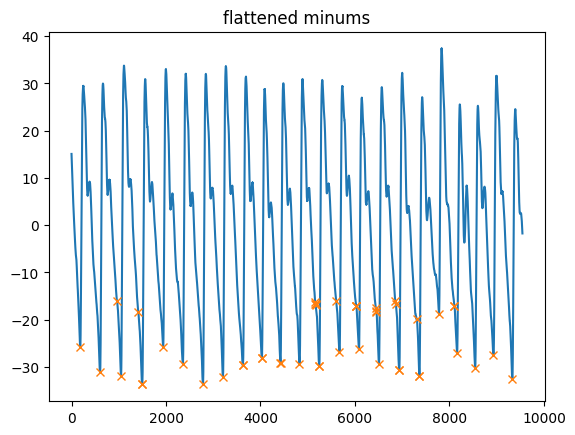

In [367]:

# df = pd.read_csv(path,sep = '\t')   
# pos_pressure = df["pressure"]
y_flater = np.array(y_flater)
neglist = [ -x for x in y_flater]

neg_max_values = max(neglist)
neg_mix_values = min(neglist)
mid_neg_value= neg_max_values - neg_mix_values
print(mid_neg_value, mid_neg_value*0.20)

min_height = neg_max_values - mid_neg_value*0.25 
print("hiii",min_height )

min_peaks, _ = find_peaks(neglist , height= min_height)


plt.plot(y_flater)
plt.plot(min_peaks, y_flater[min_peaks], "x")
plt.title("flattened minums")
plt.show()


71.10445598346632 14.220891196693266
hiii 23.041038719424524


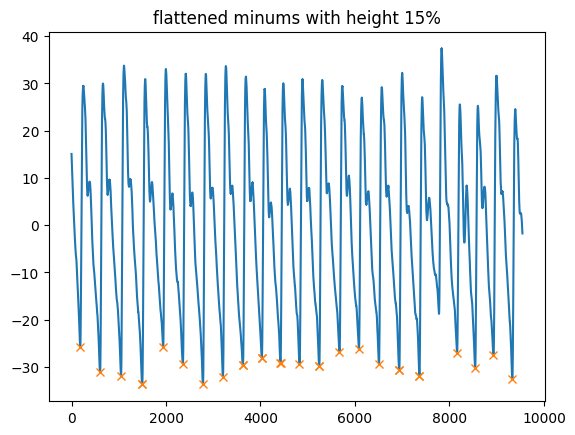

In [375]:

# df = pd.read_csv(path,sep = '\t')   
# pos_pressure = df["pressure"]
y_flater = np.array(y_flater)
neglist = [ -x for x in y_flater]

neg_max_values = max(neglist)
neg_mix_values = min(neglist)
mid_neg_value= neg_max_values - neg_mix_values
print(mid_neg_value, mid_neg_value*0.20)

min_height = neg_max_values - mid_neg_value*0.15 
print("hiii",min_height )

min_peaks, _ = find_peaks(neglist , height= min_height)


plt.plot(y_flater)
plt.plot(min_peaks, y_flater[min_peaks], "x")
plt.title("flattened minums with height 15%")
plt.show()


<class 'numpy.ndarray'>


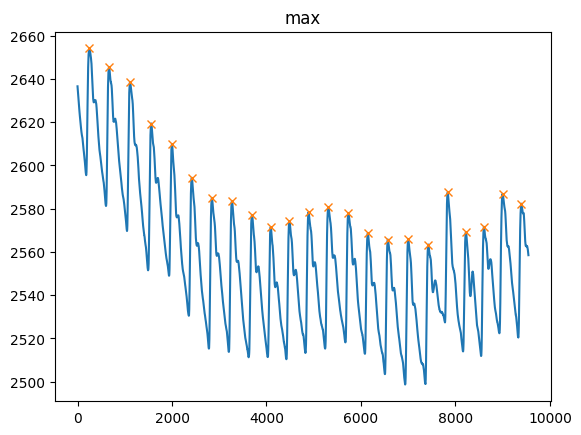

In [353]:

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]


max_peak, _ = find_peaks(pos_pressure, prominence=10,width=80
                         )

plt.plot(pos_pressure)
print(type(max_peak))
plt.plot(max_peak, pos_pressure[max_peak], "x")
plt.title("max")

plt.show()

In [354]:
#this is so i can see the diffrences in the graph widths
diffrences_min = np.diff(min_peaks)
mean_min = float(diffrences_min.mean())

diffrences_max = np.diff(max_peak)
mean_max = float(diffrences_max.mean())


print(mean_min,mean_max )

326.60714285714283 415.54545454545456


In [355]:
#this edeleuets all elemerns with in 40 of the mini
need_to_go  = []

set_max_peak = set(max_peak)
for mini in list(min_peaks):
    if len(set(range(mini-40,40+mini)).intersection(set_max_peak))>0:
        need_to_go.append(int(mini))

combo_list =  list(min_peaks)+ (need_to_go)
combo_list = [int(i) for i in combo_list]

# juts deleted stuff from both lists if its in tht 40 range
new_mins = [k for k,v in Counter(combo_list).items() if v==1]



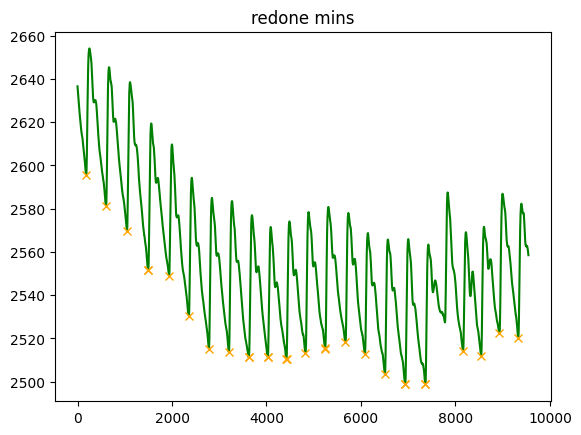

In [356]:

#fileted ghrough mins
df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]


plt.plot(pos_pressure, color="green")


newst_mins= np.asarray(list(new_mins), dtype=np.float32)

plt.plot(newst_mins, pos_pressure[newst_mins], "x", color="orange")
plt.title("redone mins")

plt.show()

This the diffrence in means:

In [357]:
#print(min_peaks,peaks)
diffrences_min = np.diff(min_peaks)

mean_min = float(diffrences_min.mean())

diffrences_max = np.diff(max_peak)

mean_max = float(diffrences_max.mean())


diffrences_new_min = np.diff(newst_mins)

mean_new_min = float(diffrences_new_min.mean())


print(mean_min,mean_max,mean_new_min )


326.60714285714283 415.54545454545456 326.6071472167969


In [358]:
diffrences_new_min

array([420., 443., 446.,   2., 443., 418., 425., 423., 418.,   2., 403.,
         2., 392.,   2., 401., 417.,   2., 428., 412., 424., 427.,   2.,
       426.,   2., 797., 382., 386., 400.], dtype=float32)

In [359]:
# here i think if i get the stats of the list i can ssee if something is weird and drop the point
#  BUTTTT HERE IS WHERE I SEE WHAT POINT HAS TO GO

def get_stats(check_list):
    standard = float(np.std(check_list))
    mean = float(np.mean(check_list))
    return [min(check_list),mean-standard-standard,mean-standard,mean,mean + standard,mean +standard+standard ,max(check_list) ]
get_stats(diffrences_new_min)[5]

727.930419921875

here is where i wanna remvoe the things tooo far away frommthe mena

so i will say noise is when the chatr is showing a beat within 20 mins of another

if something is 20+- another beat in the other list it is removed

[[0], [0], [0], [0], [1], [1], [2], [3], [4], [5], [6], [7], [8], [9], [11], [12], [14], [15], [17], [19], [20], [22], [24], [25], [27], [29], [30], [32], [34], [35], [38], [40], [41], [43], [44], [45], [47], [48], [49], [50], [51], [51], [52], [53], [54], [54], [55], [55], [56], [56], [57], [57], [57], [58], [58], [58], [58], [59], [59], [59], [60], [60], [60], [60], [60], [60], [60], [60], [60], [60], [60], [60], [60], [60], [60], [60], [60], [60], [60], [59], [59], [59], [59], [59], [58], [58], [58], [58], [58], [58], [58], [58], [58], [58], [58], [58], [58], [57], [57], [57], [57], [57], [57], [56], [56], [56], [56], [55], [55], [55], [55], [54], [54], [53], [53], [53], [52], [52], [51], [51], [51], [51], [50], [50], [49], [49], [48], [48], [47], [46], [46], [45], [45], [44], [44], [43], [43], [42], [42], [41], [41], [41], [40], [40], [40], [39], [39], [39], [39], [39], [39], [39], [39], [39], [39], [39], [39], [39], [38], [38], [38], [38], [38], [38], [39], [39], [39], [39], [39],

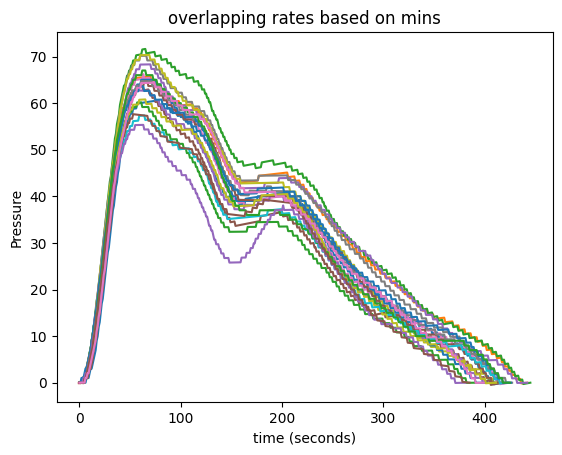

In [360]:
all_overlaps = [[] for i in range(int(max(diffrences_new_min)))]

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

newst_mins= np.asarray(list(new_mins), dtype=np.float32)

mini_list = list(newst_mins)

for i in range(len(mini_list)-1):

    if (int(mini_list[i+1]) -int(mini_list[i]))< get_stats(diffrences_new_min)[4] :
        y_range  = list(range(int(mini_list[i]),int(mini_list[i+1])))
        y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]

        x_range = list(range(int(mini_list[i]),int(mini_list[i+1])))
        x_of_shift = [int(x - x_range[0]) for x in x_range]
        start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)

        y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]


        for x_indi in range(len(x_range)):
            #print(x_indi)
            #all_overlaps[x_indi].append(
            all_overlaps[x_indi].append(int(y_of_shift[x_indi]-start_end_line[x_indi]))
        
        # um all_overlaps and y_rotated does the same thing... i think, it is but it has some error
        print(all_overlaps)
        #plt.plot(start_end_line)
        

        plt.plot(x_of_shift, y_rotated)



plt.title("overlapping rates based on mins")
plt.ylabel("Pressure")
plt.xlabel("time (seconds)")

plt.show()

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0], [2, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 0, 0, 1, 1, 3, 1, 2, 0, 1], [3, 3, 2, 2, 2, 2, 3, 3, 1, 3, 2, 0, 1, 2, 2, 3, 2, 2, 1, 1], [4, 4, 3, 2, 3, 3, 3, 4, 1, 4, 3, 0, 2, 2, 3, 4, 3, 3, 2, 2], [5, 5, 4, 3, 4, 4, 4, 5, 1, 5, 4, 1, 3, 3, 4, 5, 4, 4, 3, 2], [6, 6, 6, 4, 5, 5, 6, 6, 2, 6, 5, 2, 4, 4, 5, 6, 5, 5, 4, 3], [7, 7, 7, 5, 6, 6, 7, 7, 3, 7, 6, 2, 5, 5, 6, 7, 6, 6, 5, 4], [8, 8, 8, 6, 8, 7, 8, 9, 3, 9, 8, 3, 6, 6, 7, 9, 7, 7, 6, 5], [9, 10, 10, 7, 9, 9, 10, 10, 4, 10, 9, 4, 8, 7, 8, 10, 9, 9, 7, 6], [11, 11, 11, 9, 11, 10, 12, 12, 5, 12, 11, 6, 9, 9, 10, 12, 10, 10, 9, 7], [12, 13,

/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


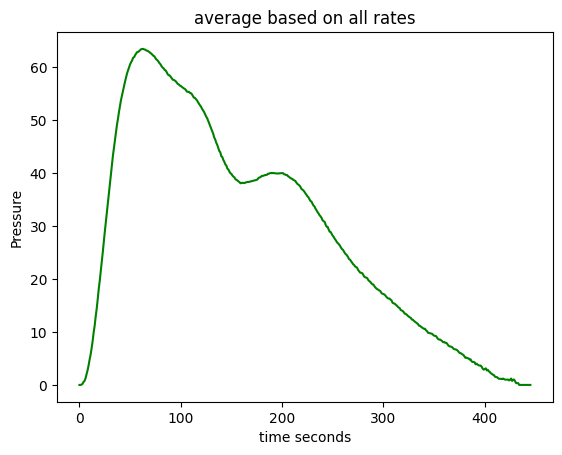

In [361]:
#to get data for the overall mean 
all_overlaps_means = []
#mean for each row
for lists in all_overlaps:
    all_overlaps_means.append(np.mean(lists))

print(all_overlaps)
all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']
plt.plot(all_overlaps_means, color='green')
plt.title("average based on all rates")
plt.ylabel("Pressure")
plt.xlabel("time seconds")
contecting_it = np.linspace(all_overlaps_means[0], all_overlaps_means[-1], len(all_overlaps_means), endpoint=True)
#plt.plot(contecting_it)
plt.show()
all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']


In [362]:
print(contecting_it)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

IMPOETANPINTS

In [363]:
all_overlaps_means

[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.05),
 np.float64(0.2),
 np.float64(0.55),
 np.float64(0.75),
 np.float64(1.25),
 np.float64(2.0),
 np.float64(2.75),
 np.float64(3.65),
 np.float64(4.75),
 np.float64(5.7),
 np.float64(6.9),
 np.float64(8.25),
 np.float64(9.85),
 np.float64(11.15),
 np.float64(12.85),
 np.float64(14.35),
 np.float64(16.1),
 np.float64(18.05),
 np.float64(19.6),
 np.float64(21.35),
 np.float64(23.15),
 np.float64(25.0),
 np.float64(27.0),
 np.float64(28.85),
 np.float64(30.65),
 np.float64(32.5),
 np.float64(34.4),
 np.float64(36.1),
 np.float64(37.95),
 np.float64(39.7),
 np.float64(41.45),
 np.float64(43.2),
 np.float64(44.65),
 np.float64(46.2),
 np.float64(47.7),
 np.float64(49.05),
 np.float64(50.2),
 np.float64(51.5),
 np.float64(52.65),
 np.float64(53.75),
 np.float64(54.65),
 np.float64(55.6),
 np.float64(56.45),
 np.float64(57.25),
 np.float64(58.05),
 np.float64(58.8),
 np.float64(59.35),
 np.float64(59.9),
 np.float64(60.5),
 np.float64(60.9),

In [364]:
all_overlaps_means

print(len(all_overlaps_means))

print(all_overlaps_means)



446
[np.float64(0.0), np.float64(0.0), np.float64(0.05), np.float64(0.2), np.float64(0.55), np.float64(0.75), np.float64(1.25), np.float64(2.0), np.float64(2.75), np.float64(3.65), np.float64(4.75), np.float64(5.7), np.float64(6.9), np.float64(8.25), np.float64(9.85), np.float64(11.15), np.float64(12.85), np.float64(14.35), np.float64(16.1), np.float64(18.05), np.float64(19.6), np.float64(21.35), np.float64(23.15), np.float64(25.0), np.float64(27.0), np.float64(28.85), np.float64(30.65), np.float64(32.5), np.float64(34.4), np.float64(36.1), np.float64(37.95), np.float64(39.7), np.float64(41.45), np.float64(43.2), np.float64(44.65), np.float64(46.2), np.float64(47.7), np.float64(49.05), np.float64(50.2), np.float64(51.5), np.float64(52.65), np.float64(53.75), np.float64(54.65), np.float64(55.6), np.float64(56.45), np.float64(57.25), np.float64(58.05), np.float64(58.8), np.float64(59.35), np.float64(59.9), np.float64(60.5), np.float64(60.9), np.float64(61.25), np.float64(61.75), np.float

[-7.52696528e-02  3.52113462e+00  1.58675010e+01  3.20481647e+01
  4.72042440e+01  5.69542313e+01  6.18807715e+01  6.32783069e+01
  6.24648000e+01  6.03629461e+01  5.83185958e+01  5.66470813e+01
  5.54030576e+01  5.36220190e+01  5.07421196e+01  4.63747157e+01
  4.21649882e+01  3.93200385e+01  3.81572861e+01  3.83964140e+01
  3.91603674e+01  3.98693028e+01  3.99550348e+01  3.95114334e+01
  3.81612512e+01  3.61719461e+01  3.35945183e+01  3.09113339e+01
  2.82243938e+01  2.57886934e+01  2.34519728e+01  2.14345538e+01
  1.97290101e+01  1.80363940e+01  1.66114312e+01  1.51111522e+01
  1.35275085e+01  1.21087591e+01  1.07020114e+01  9.56957495e+00
  8.41824449e+00  7.34800720e+00  6.17307888e+00  4.98471236e+00
  3.86449007e+00  2.89488065e+00  1.59713718e+00  1.08451618e+00
  7.58752322e-01  5.45167243e-02]
[197.5        -29.96613204  38.65862241  12.83336482  45.99015431
  36.52197566  60.07602579  56.99462919  75.95373718  76.36456843
  92.5585738   95.23008783 109.5271363  113.82529994 1

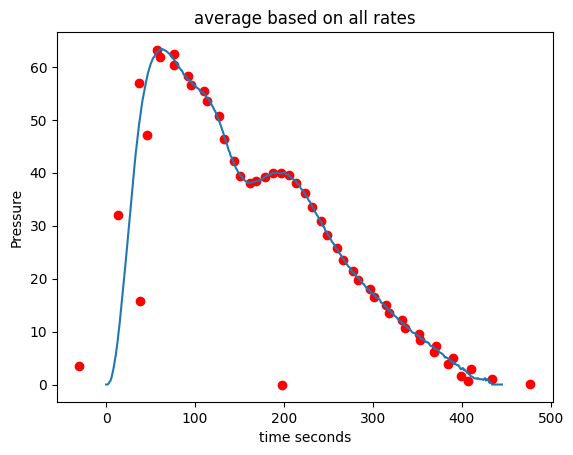

In [365]:
#to get data for the overall mean 
all_overlaps_means = []
#mean for each row
for lists in all_overlaps:
    all_overlaps_means.append(np.mean(lists))


all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']





resampled_y = signal.resample(all_overlaps_means, 50)
resampled_x = signal.resample(list(range(len(all_overlaps_means))), 50)
print((resampled_y))
print((resampled_x))

plt.plot(resampled_x,resampled_y,  'ro' )
#plt.plot(resampled_y,  'ro' )
print(len(all_overlaps_means))
plt.plot(all_overlaps_means )

plt.title("average based on all rates")
plt.ylabel("Pressure")
plt.xlabel("time seconds")

plt.show()

all_overlaps_means[0::10]

In [366]:
new_50 = [[x,y] for x, y in zip(resampled_x, resampled_y)]
new_50

[[np.float64(197.50000000000014), np.float64(-0.07526965283987705)],
 [np.float64(-29.966132038493612), np.float64(3.521134623503566)],
 [np.float64(38.65862240679108), np.float64(15.86750099152426)],
 [np.float64(12.833364819889605), np.float64(32.04816473552615)],
 [np.float64(45.99015431412962), np.float64(47.204243991691925)],
 [np.float64(36.52197566376462), np.float64(56.95423133857989)],
 [np.float64(60.076025792739436), np.float64(61.88077147980824)],
 [np.float64(56.99462919409968), np.float64(63.2783069262163)],
 [np.float64(75.95373718312543), np.float64(62.464800014661016)],
 [np.float64(76.36456842543504), np.float64(60.36294611018257)],
 [np.float64(92.558573803154), np.float64(58.318595807882616)],
 [np.float64(95.23008782645611), np.float64(56.64708134990784)],
 [np.float64(109.52713629562237), np.float64(55.40305758206476)],
 [np.float64(113.82529994102649), np.float64(53.622019014461394)],
 [np.float64(126.70141798757106), np.float64(50.742119616291994)],
 [np.float64